In [1]:
!pip install transformers
!pip install datasets
!pip install tqdm

In [1]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
import torch.nn as nn

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')
print(model.modules)

/home/piragi/projects/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/piragi/projects/env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


<bound method Module.modules of GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)>


In [2]:
from transformers.pytorch_utils import Conv1D
import torch.nn as nn

class LoRAConv1D(nn.Module):
    def __init__(self, weight, bias, r, alpha):
        super(LoRAConv1D, self).__init__()
        self.nx, self.nf = weight.shape 
        self.weight = weight
        self.weight.requires_grad = False
        self.bias = bias
        self.r = r
        self.alpha = alpha
        # Initialize A and B with small random values
        self.A = nn.Parameter(torch.randn(self.r, self.nx) * 0.02)
        self.B = nn.Parameter(torch.randn(self.nf, self.r) * 0.02)
    
    def forward(self, x):
        size_out = x.size()[:-1] + (self.nf,)
        result = torch.addmm(self.bias, x.view(-1, x.size(-1)), self.weight)
        low_rank = self.B @ self.A
        result += (self.alpha / self.r) * x.view(-1, x.size(-1)) @ low_rank.T
        result = result.view(size_out)
        return result

In [3]:
#replace all the attention layers in model with LoRA layers
r = 2
alpha = 16
for name, module in model.named_modules():
    if isinstance(module, Conv1D) and "c_attn" in str(name):
        lora_layer = LoRAConv1D(module.weight, module.bias, r, alpha)
        # Replace the module directly in the parent's _modules dictionary
        parent_name, child_name = name.rsplit('.', 1)
        parent_module = dict(model.named_modules())[parent_name]
        parent_module._modules[child_name] = lora_layer

In [12]:
for name, param in model.named_parameters():
    param.requires_grad = False

# Then, set only A and B in LoRAConv1D modules to require gradients
for name, module in model.named_modules():
    if isinstance(module, LoRAConv1D):
        module.A.requires_grad = True
        module.B.requires_grad = True

# Verify the setup
for name, param in model.named_parameters():
    if "attn.c_attn.A" in name or "attn.c_attn.B" in name:
        assert param.requires_grad == True, f"{name} should require gradients"
    else:
        assert param.requires_grad == False, f"{name} should not require gradients"

print(model)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): LoRAConv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)
73728


In [4]:
for _, param in model.named_parameters():
    param.requires_grad = False

for name, module in model.named_modules():
    if isinstance(module, LoRAConv1D):
        for param in module.parameters():
            param.requires_grad = True

for name, param in model.named_parameters():
    if "attn.c_attn" in name: assert param.requires_grad == True
    else: assert param.requires_grad == False
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): LoRAConv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


In [9]:
r=0
for _, param in model.named_parameters():
    param.requires_grad = False

for name, module in model.named_modules():
    if "attn.c_" in name:
        for name, param in module.named_parameters():
            if 'weight' in name:
                param.requires_grad = True
            elif 'bias' in name:
                param.requires_grad = False

for name, param in model.named_parameters():
    if "attn.c_" in name and "weight" in name:
        assert param.requires_grad == True, f"Weight parameter {name} should require gradients"
    else:
        assert param.requires_grad == False, f"Parameter {name} should not require gradients"


In [3]:
models = ["gpt2_r2_epoch2_ppl26.14", "gpt2_r0_epoch1_ppl25.75", "gpt2_r256_epoch3_ppl25.90", "gpt2_r8_epoch3_ppl25.98"]
for model_name in models:
    model = torch.load(f'./{model_name}.ppt')
    pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'load {model_name} with total params: {pytorch_total_params}')    

load gpt2_r2_epoch2_ppl26.14 with total params: 21335040
load gpt2_r0_epoch1_ppl25.75 with total params: 28348416
load gpt2_r256_epoch3_ppl25.90 with total params: 30698496
load gpt2_r8_epoch3_ppl25.98 with total params: 21556224


In [4]:
from prettytable import PrettyTable
import torch

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params += param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

models = ["gpt2_r2_epoch4_ppl26.63", "gpt2_r0_epoch1_ppl25.75", "gpt2_r64_epoch7_ppl26.27", "gpt2_r8_epoch7_ppl26.26"]

for model_name in models:
    model = torch.load(f'./{model_name}.ppt')
    print(f"Model: {model_name}")
    print(model)  # This will print the model architecture
    count_parameters(model)
    print("\n")

Model: gpt2_r2_epoch4_ppl26.63
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): LoRAConv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)
+--------------------------------+------------+
|            Modules         

In [5]:
import torch
from torch.cuda.amp import GradScaler, autocast
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, get_scheduler
from tqdm import tqdm

def train_and_evaluate_model(model, model_name="gpt2", dataset_name="wikitext-2-raw-v1", num_epochs=5, batch_size=4, learning_rate=2e-5, weight_decay=0.01, warmup_steps=500, max_length=512):
    # Load dataset
    dataset = load_dataset('wikitext', dataset_name)
    train_texts, val_texts, test_texts = dataset['train']['text'], dataset['validation']['text'], dataset['test']['text']

    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token

    # Tokenize data and create datasets
    def tokenize_and_create_dataset(texts):
        encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
        return TensorDataset(encodings['input_ids'], encodings['attention_mask'])

    train_dataset = tokenize_and_create_dataset(train_texts)
    val_dataset = tokenize_and_create_dataset(val_texts)
    test_dataset = tokenize_and_create_dataset(test_texts)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Setup device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Setup optimization
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    num_training_steps = len(train_loader) * num_epochs
    lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=warmup_steps, num_training_steps=num_training_steps)

    # Mixed Precision
    scaler = GradScaler()

    # Training and Validation
    best_val_perplexity = float('inf')
    for epoch in range(num_epochs):
        train_epoch(model, train_loader, optimizer, lr_scheduler, scaler, device, epoch)
        val_perplexity = evaluate_model(model, tokenizer, val_texts, device)
        
        if val_perplexity < best_val_perplexity:
            best_val_perplexity = val_perplexity
        save_model(model, tokenizer, val_perplexity, epoch)

def train_epoch(model, train_loader, optimizer, lr_scheduler, scaler, device, epoch):
    model.train()
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for batch in progress_bar:
        optimizer.zero_grad()
        inputs, masks = [b.to(device) for b in batch]
        
        with autocast():
            outputs = model(inputs, attention_mask=masks, labels=inputs)
            loss = outputs.loss
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        progress_bar.set_postfix(training_loss=loss.item())
    lr_scheduler.step()


def evaluate_model(model, tokenizer, test_texts, device):
    model.eval()
    max_length = model.config.n_positions
    stride = 512
    encodings = tokenizer("\n\n".join(test_texts), return_tensors="pt")
    seq_len = encodings.input_ids.size(1)

    nlls = []
    prev_end_loc = 0
    for begin_loc in range(0, seq_len, stride):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            neg_log_likelihood = outputs.loss
        nlls.append(neg_log_likelihood)
        
        prev_end_loc = end_loc
        if end_loc == seq_len:
            break

    ppl = torch.exp(torch.stack(nlls).mean())
    print(f"Perplexity: {ppl.item()}")
    return ppl.item()

def save_model(model, tokenizer, val_perplexity, epoch):
    torch.save(model, f'./gpt2_r{r}_epoch{epoch}_ppl{val_perplexity:.2f}.ppt')
    print(f"Saved model with validation perplexity: {val_perplexity:.2f}")


train_and_evaluate_model(
    model,
    model_name="gpt2",
    dataset_name="wikitext-2-raw-v1",
    num_epochs=5,
    batch_size=8,
    learning_rate=1e-5,
    weight_decay=0.01,
    warmup_steps=500,
    max_length=512
)


KeyboardInterrupt: 

In [7]:
models = ["gpt2_r2_epoch4_ppl26.63", "gpt2_r0_epoch4_ppl25.84", "gpt2_r64_epoch7_ppl26.27", "gpt2_r8_epoch7_ppl26.26", "gpt2_r8_epoch4_ppl26.39", "gpt2_r2_epoch2_ppl26.06"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = load_dataset('wikitext', "wikitext-2-raw-v1")
val_texts = dataset['test']['text']
for model_name in models:
    model = torch.load(f'./{model_name}.ppt')
    pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'load {model_name} with total params: {pytorch_total_params}')    
    model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    evaluate_model(model, tokenizer, val_texts, device)

load gpt2_r2_epoch4_ppl26.63 with total params: 73728
Perplexity: 25.429397583007812
load gpt2_r0_epoch4_ppl25.84 with total params: 21233664
Perplexity: 24.683578491210938
load gpt2_r64_epoch7_ppl26.27 with total params: 2359296
Perplexity: 25.07568359375
load gpt2_r8_epoch7_ppl26.26 with total params: 294912
Perplexity: 25.082033157348633
load gpt2_r8_epoch4_ppl26.39 with total params: 294912
Perplexity: 25.192895889282227
load gpt2_r2_epoch2_ppl26.06 with total params: 73728
Perplexity: 24.915809631347656


In [14]:
model = GPT2LMHeadModel.from_pretrained('gpt2')
print(f'load gpt2')    
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
evaluate_model(model, tokenizer, val_texts, device)

/home/piragi/projects/env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


load gpt2
Perplexity: 25.1879940032959


25.1879940032959

In [9]:
def extract_lora_matrices(model, target_modules=["c_attn"]):
    lora_matrices = {}
    for name, module in model.named_modules():
        if hasattr(module, 'A') and hasattr(module, 'B'):
            if any(target in name for target in target_modules):
                lora_A = module.A.detach()
                lora_B = module.B.detach()
                adaptation_matrix = lora_B @ lora_A
                lora_matrices[name] = adaptation_matrix
    return lora_matrices

def extract_c_attn_matrices(model, target_modules=["c_attn"]):
    weight_matrices = {}
    for name, module in model.named_modules():
        if hasattr(module, 'weight'):
            if any(target in name for target in target_modules):
                weight = module.weight.detach()
                weight_matrices[name] = weight
    return weight_matrices

r8_model = torch.load("gpt2_r8_epoch7_ppl26.26.ppt")
r8_matrices = extract_lora_matrices(r8_model)
print("r8 matrices:", r8_matrices.keys())
A_r8 = r8_matrices['transformer.h.5.attn.c_attn']
r64_model = torch.load("gpt2_r64_epoch7_ppl26.27.ppt")
r64_matrices = extract_lora_matrices(r64_model)
print("r64 matrices:", r64_matrices.keys())
A_r64 = r64_matrices['transformer.h.5.attn.c_attn']
r2_model = torch.load("gpt2_r2_epoch2_ppl26.14.ppt")
r2_matrices = extract_lora_matrices(r2_model)
print("r2 matrices:", r2_matrices.keys())
A_r2 = r2_matrices['transformer.h.5.attn.c_attn']
r0_model = torch.load("gpt2_r0_epoch4_ppl25.84.ppt")
r0_matrices = extract_c_attn_matrices(r0_model)
print("r0 matrices:", r0_matrices.keys())
A_r0 = r0_matrices['transformer.h.5.attn.c_attn']

r8 matrices: dict_keys(['transformer.h.0.attn.c_attn', 'transformer.h.1.attn.c_attn', 'transformer.h.2.attn.c_attn', 'transformer.h.3.attn.c_attn', 'transformer.h.4.attn.c_attn', 'transformer.h.5.attn.c_attn', 'transformer.h.6.attn.c_attn', 'transformer.h.7.attn.c_attn', 'transformer.h.8.attn.c_attn', 'transformer.h.9.attn.c_attn', 'transformer.h.10.attn.c_attn', 'transformer.h.11.attn.c_attn'])
r64 matrices: dict_keys(['transformer.h.0.attn.c_attn', 'transformer.h.1.attn.c_attn', 'transformer.h.2.attn.c_attn', 'transformer.h.3.attn.c_attn', 'transformer.h.4.attn.c_attn', 'transformer.h.5.attn.c_attn', 'transformer.h.6.attn.c_attn', 'transformer.h.7.attn.c_attn', 'transformer.h.8.attn.c_attn', 'transformer.h.9.attn.c_attn', 'transformer.h.10.attn.c_attn', 'transformer.h.11.attn.c_attn'])
r2 matrices: dict_keys(['transformer.h.0.attn.c_attn', 'transformer.h.1.attn.c_attn', 'transformer.h.2.attn.c_attn', 'transformer.h.3.attn.c_attn', 'transformer.h.4.attn.c_attn', 'transformer.h.5.attn.

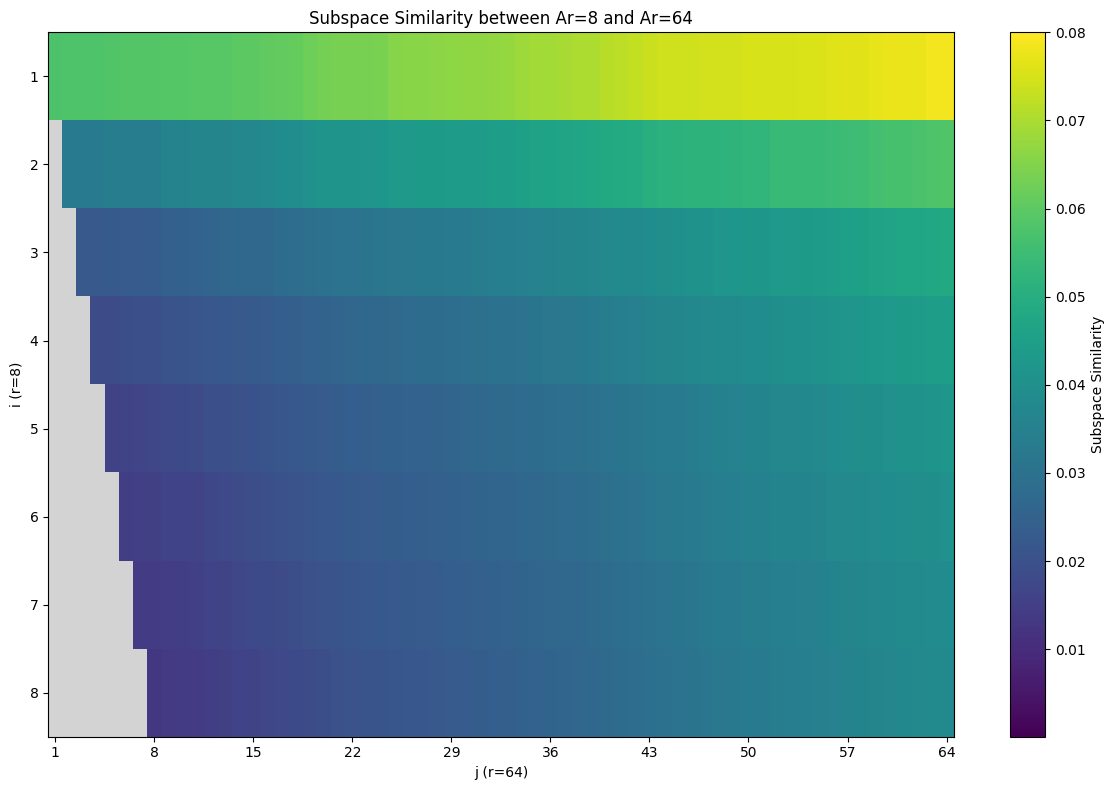

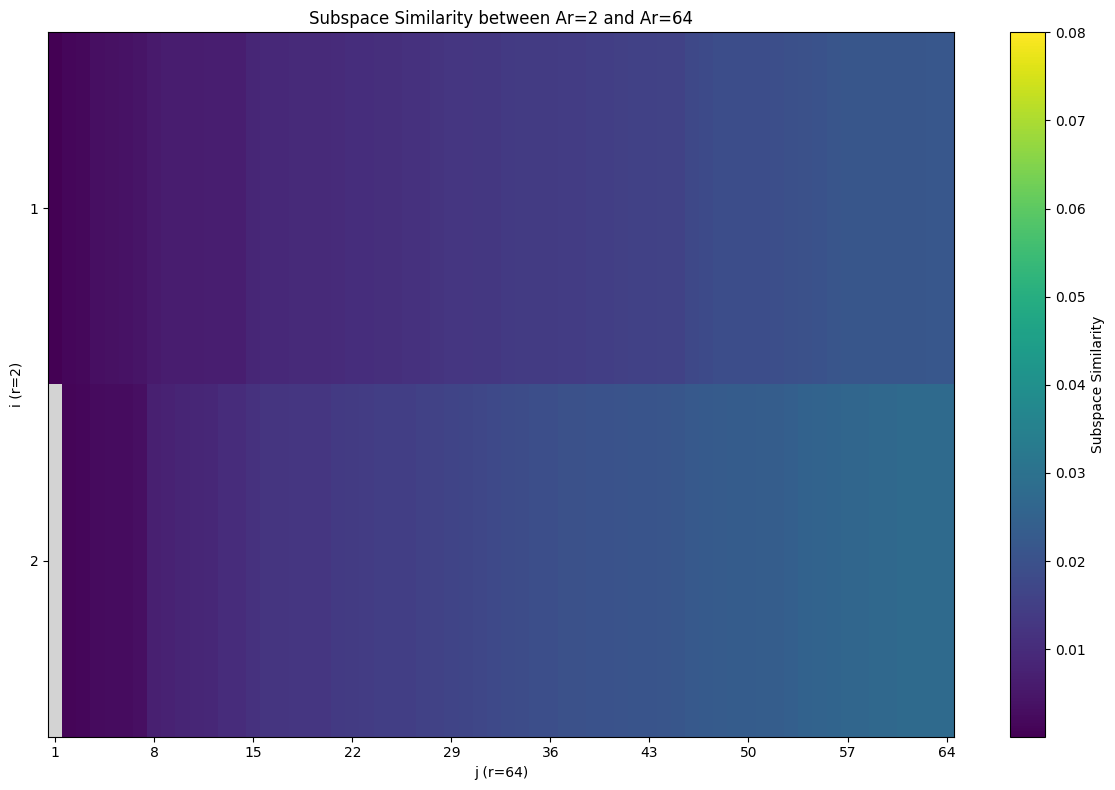

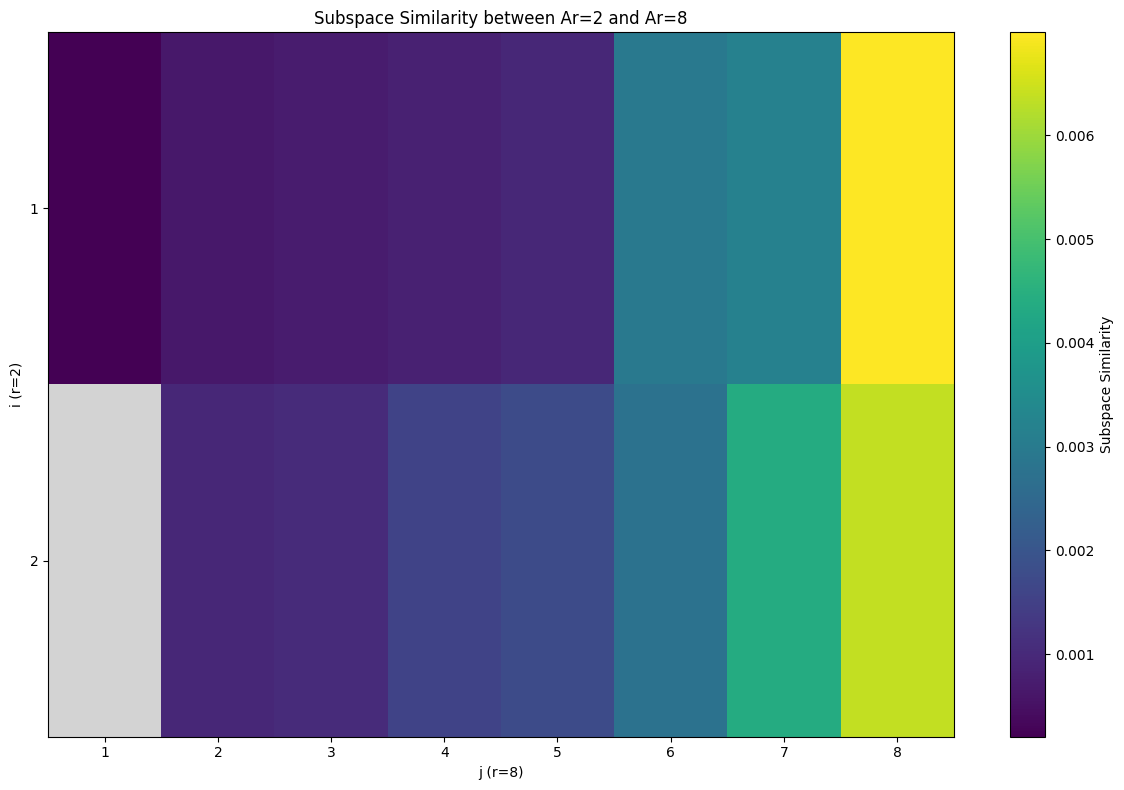

In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def subspace_similarity_gpu(A1, A2, r1, r2):
    # Move matrices to GPU
    A1 = A1.cuda()
    A2 = A2.cuda()
    
    # Perform SVD once for each matrix
    U1 = torch.linalg.svd(A1, full_matrices=False)[0]
    U2 = torch.linalg.svd(A2, full_matrices=False)[0]
    
    max_i, max_j = r1, r2
    similarity_matrix = torch.zeros((max_i, max_j), device='cuda')
    
    for i in range(1, max_i + 1):
        for j in range(1, max_j + 1):
            U1_i = U1[:, :i]
            U2_j = U2[:, :j]
            
            # Calculate Frobenius norm squared of U1_i.T @ U2_j
            similarity = torch.norm(U1_i.T @ U2_j, p='fro')**2 / min(i, j)
            similarity_matrix[i-1, j-1] = similarity
    
    return similarity_matrix.cpu().numpy()


def plot_subspace_similarity(similarity_matrix, title, r1, r2, vmin, vmax):
    plt.figure(figsize=(12, 8))
    
    # Create a mask that greys out the lower left triangle, starting one row lower
    mask = np.zeros_like(similarity_matrix, dtype=bool)
    for i in range(similarity_matrix.shape[0]):
        mask[i, :min(i, similarity_matrix.shape[1])] = True
    
    # Create a custom colormap with grey for masked values
    cmap = plt.get_cmap('viridis').copy()
    cmap.set_bad(color='lightgrey')
    
    # Apply the mask
    masked_data = np.ma.array(similarity_matrix, mask=mask)
    
    im = plt.imshow(masked_data, cmap=cmap, aspect='auto', vmin=vmin, vmax=vmax)
    plt.colorbar(im, label='Subspace Similarity')
    
    # Set x-axis ticks and labels
    plt.xlabel(f'j (r={r2})')
    x_ticks = np.linspace(0, r2-1, min(r2, 10), dtype=int)
    plt.xticks(x_ticks, x_ticks + 1)
    
    # Set y-axis ticks and labels
    plt.ylabel(f'i (r={r1})')
    y_ticks = np.arange(r1)
    plt.yticks(y_ticks, y_ticks + 1)
    
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Calculate all similarity matrices first
sim_8_64 = subspace_similarity_gpu(A_r8, A_r64, 8, 64)
sim_2_64 = subspace_similarity_gpu(A_r2, A_r64, 2, 64)
sim_2_8 = subspace_similarity_gpu(A_r2, A_r8, 2, 8)

# Find global min and max
all_sims = np.concatenate([sim_8_64.flatten(), sim_2_64.flatten(), sim_2_8.flatten()])
global_min = np.min(all_sims)
global_max = np.max(all_sims)

# Plot all with the same color scale
plot_subspace_similarity(sim_8_64, "Subspace Similarity between Ar=8 and Ar=64", 8, 64, global_min, global_max)
plot_subspace_similarity(sim_2_64, "Subspace Similarity between Ar=2 and Ar=64", 2, 64, global_min, global_max)


all_sims = np.concatenate([sim_2_8.flatten()])
global_min = np.min(all_sims)
global_max = np.max(all_sims)
plot_subspace_similarity(sim_2_8, "Subspace Similarity between Ar=2 and Ar=8", 2, 8, global_min, global_max)


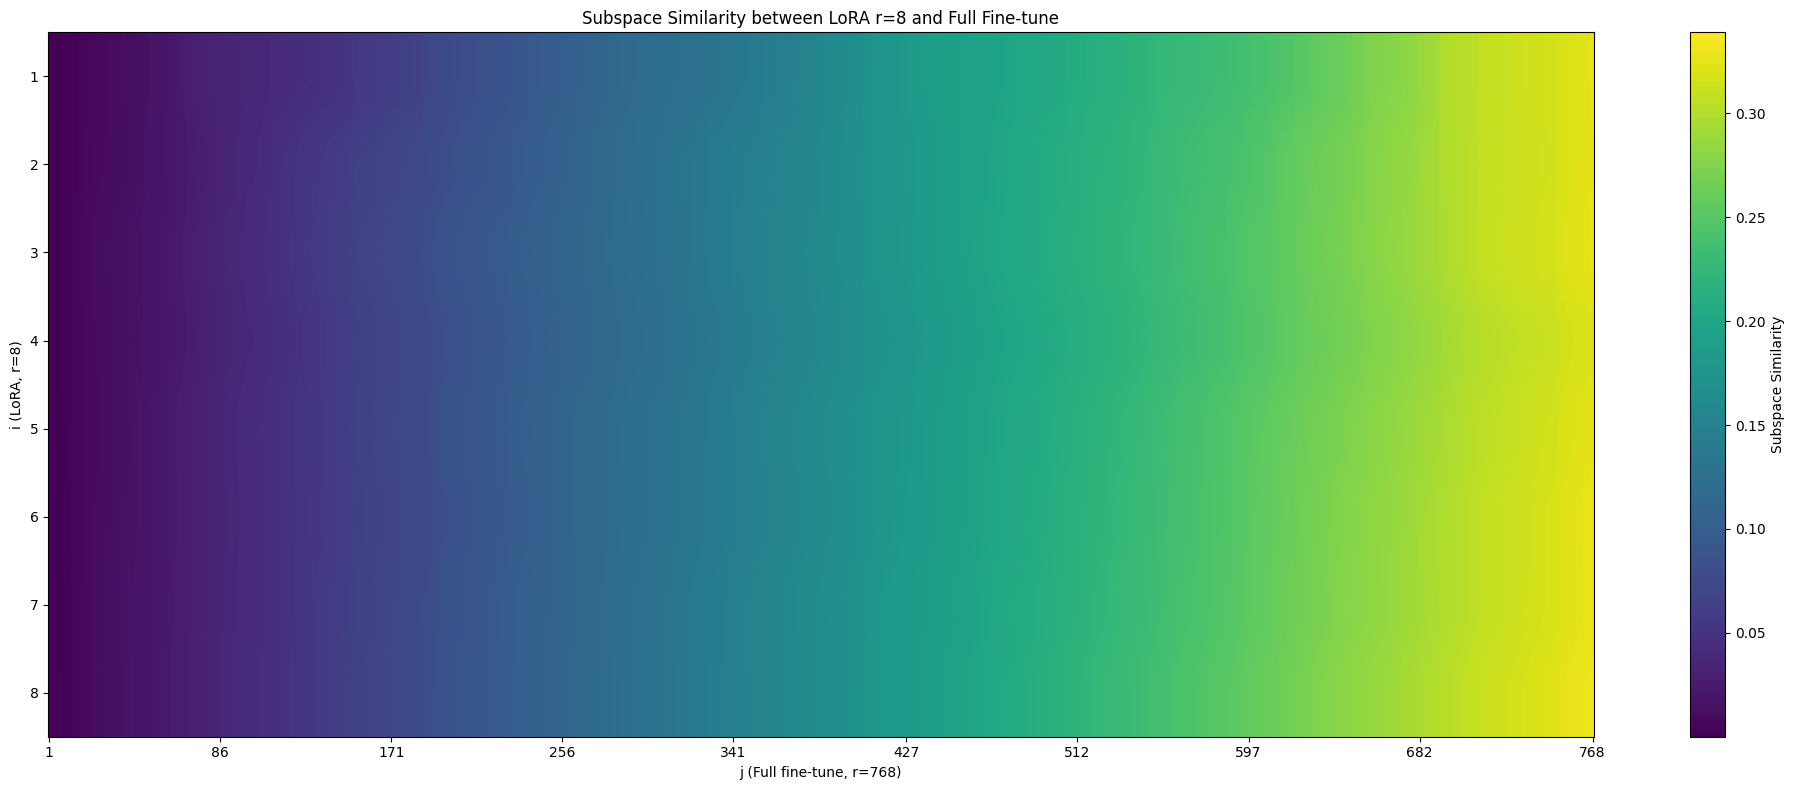

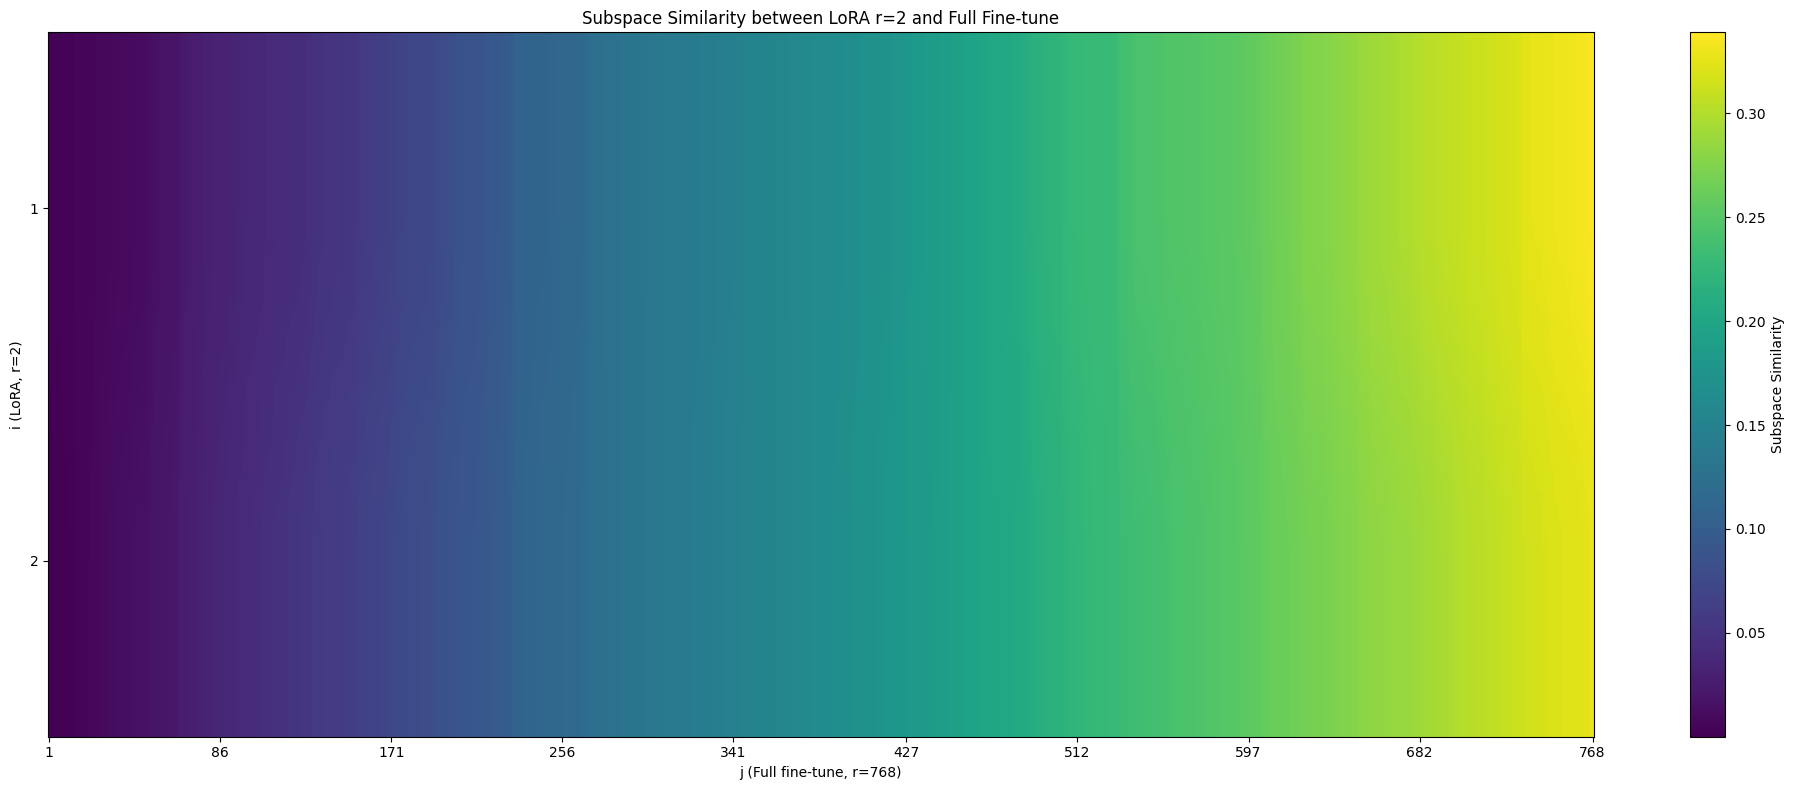

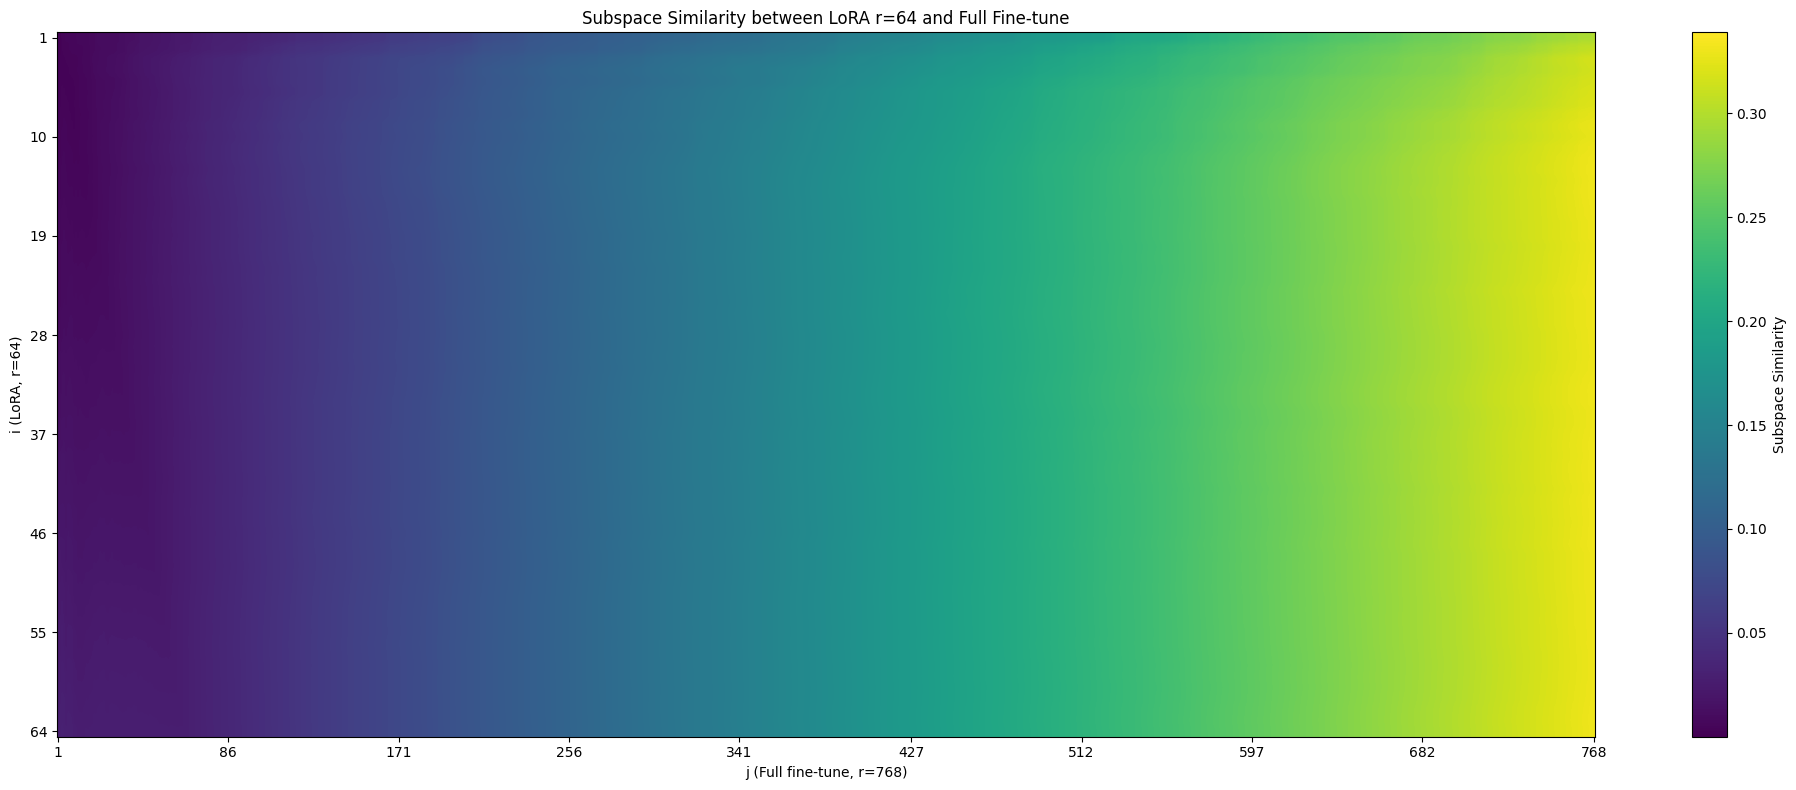

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def subspace_similarity_gpu(A_lora, W_diff, r_lora):
    A_lora = A_lora.cuda()
    W_diff = W_diff.cuda()
    
    # Ensure correct orientation
    if A_lora.shape[0] < A_lora.shape[1]:
        A_lora = A_lora.T
    if W_diff.shape[0] < W_diff.shape[1]:
        W_diff = W_diff.T
    
    # Compute SVD
    U_lora = torch.linalg.svd(A_lora, full_matrices=False)[0]
    U_diff = torch.linalg.svd(W_diff, full_matrices=False)[0]
    
    max_i, max_j = r_lora, W_diff.shape[1]
    similarity_matrix = torch.zeros((max_i, max_j), device='cuda')
    
    for i in range(1, max_i + 1):
        for j in range(1, max_j + 1):
            U_lora_i = U_lora[:, :i]
            U_diff_j = U_diff[:, :j]
            
            similarity = torch.norm(U_lora_i.T @ U_diff_j, 'fro')**2 / min(i, j)
            similarity_matrix[i-1, j-1] = similarity
    
    return similarity_matrix.cpu().numpy()

def plot_subspace_similarity(similarity_matrix, title, r1, r2, vmin, vmax):
    plt.figure(figsize=(20, 8))  # Increased figure width
    im = plt.imshow(similarity_matrix, cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
    plt.colorbar(im, label='Subspace Similarity')
    
    plt.xlabel(f'j (Full fine-tune, r={r2})')
    x_ticks = np.linspace(0, similarity_matrix.shape[1]-1, 10, dtype=int)
    plt.xticks(x_ticks, [f'{x+1}' for x in x_ticks])
    
    plt.ylabel(f'i (LoRA, r={r1})')
    if r1 <= 8:
        y_ticks = np.arange(r1)
        plt.yticks(y_ticks, y_ticks + 1)
    elif r1 <= 64:
        y_ticks = np.linspace(0, r1-1, 8, dtype=int)
        plt.yticks(y_ticks, y_ticks + 1)
    else:
        plt.yticks([])  # Remove y-axis ticks for r > 64
    
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Calculate similarity matrices
sim_8_full = subspace_similarity_gpu(A_r8, A_r0, 8)
sim_2_full = subspace_similarity_gpu(A_r2, A_r0, 2)
sim_64_full = subspace_similarity_gpu(A_r64, A_r0, 64)

# Find global min and max
all_sims = np.concatenate([sim_8_full.flatten(), sim_2_full.flatten(), sim_64_full.flatten()])
global_min = np.min(all_sims)
global_max = np.max(all_sims)

# Plot with consistent color scale
plot_subspace_similarity(sim_8_full, "Subspace Similarity between LoRA r=8 and Full Fine-tune", 8, sim_8_full.shape[1], global_min, global_max)
plot_subspace_similarity(sim_2_full, "Subspace Similarity between LoRA r=2 and Full Fine-tune", 2, sim_2_full.shape[1], global_min, global_max)
plot_subspace_similarity(sim_64_full, "Subspace Similarity between LoRA r=64 and Full Fine-tune", 64, sim_64_full.shape[1], global_min, global_max)